In [1]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from datasets import load_from_disk
import json
import os
import pickle


In [2]:
model_name = "meta-llama/Llama-3.1-8B"




In [3]:
# Evaluate the model responses an accuracy
import hashlib
import re
import sys

import numpy as np


def unescape(str):
    placeholder = "<TMP>"
    assert placeholder not in str
    return str.replace("\\\\n", placeholder).replace("\\n", "\n").replace(placeholder, "\\n").replace("\\\\r", placeholder).replace("\\r", "\r").replace(placeholder, "\\r")


def parse_output(output):
    if len(output) == 0:
        return "FAILED"

    output_hash = hashlib.md5(output.encode("utf-8")).hexdigest()
    if output_hash in {"a7994fde4fba7d27500e6f03008abd7c"}:
        return "FAILED"

    output = output.replace(",", "").replace("С", "C")

    if (match := re.search("^[0-9A-Z]+$", output)) is not None:
        return output

    output = output.rstrip("\n$ `")
    if output.endswith("\n"):
        output = output[:-1]
    output = output.replace("\\text{", "")

    boxed_regex = r"boxed{(\\text{)?(result=)?([0-9A-Z]+(_{?[0-9]+}?)?\s*\+\s*[0-9A-Z]+(_{?[0-9]+}?)?\s*=\s*)?(0x)?([0-9A-Za-f \\.]+)(_ ?{?(base-)?([0-9]+|ten)}?)?}?(_{?([0-9]+|ten)}?)?}"
    get_result_from_boxed_regex = lambda match: match[-6].replace(" ", "").replace("\\", "")
    # match all \boxed{...} but also make sure there's only one match
    match = re.findall(boxed_regex, output)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    last_line = output.split("\n")[-1]
    match = re.findall(boxed_regex, last_line)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    last_line = output.rstrip(" .").split(".")[-1]
    match = re.findall(boxed_regex, last_line)
    if len(match) >= 1 and all(get_result_from_boxed_regex(m) == get_result_from_boxed_regex(match[0]) for m in match):
        return get_result_from_boxed_regex(match[0])

    if (match := re.search(r"\\boxed{[0-9A-Z]+}(_{?[0-9]+}?)?\s*\+\s*\\boxed{[0-9A-Z]+}(_{?[0-9]+}?)?\s*=\s*\\boxed{([0-9A-Z]+)}(_{?[0-9]+}?)?\.?$", last_line)) is not None:
        return match.groups()[-2]

    if (match := re.search(r"\\boxed{([0-9A-Z]+)_{?[0-9]+}?\s*=\s*[0-9A-Z]+_{?10}?}\$?\.?$", last_line)) is not None:
        return match.groups()[0]

    if (match := re.search(r"\$?[0-9A-Z]+(_{?[0-9]+}?)\s*\+\s*[0-9A-Z]+(_{?[0-9]+}?)\s*=\s*(0x)?([0-9A-Z]+)(_{?[0-9]+}?)\$?( in base-[0-9]+)?\.?$", output)) is not None:
        return match.groups()[-3]

    if (match := re.search(r"(=|is):?\s*\$?\\boxed{(0x)?([0-9A-Z]+)}\$? \(?in base-[0-9]+\)?,?( and| or| =) \$?\\boxed{(0x)?[0-9A-Z]+}\$? \(?in (base-10|decimal)\)?\.?$", output)) is not None:
        return match.groups()[2]
    if (match := re.search(r"(=|is):?\s*\$?\\boxed{(0x)?[0-9A-Z]+}\$? \(?in (base-10|decimal)\)?,?( and| or| =) \$?\\boxed{(0x)?([0-9A-Z]+)}\$? \(?in base-[0-9]+\)?\.?$", output)) is not None:
        return match.groups()[-1]
    # \boxed{207}_{10}$ which in base-11 is $\boxed{18A}$.
    if (match := re.search(r"\\boxed{[0-9A-Z]+}_\{10\}\$? which in base-[0-9]+ is \$?\\boxed{(0x)?([0-9A-Z]+)}\$?\.?$", output)) is not None:
        return match.groups()[-1]
    # 39 + 31 = 5A\boxed{}
    if (match := re.search(r"[0-9]+\s*\+\s*[0-9]+\s*=\s*([0-9A-Z]+)\\boxed\{\}\.?$", output)) is not None:
        return match.groups()[-1]

    # \boxed{result}\n62
    if (match := re.search(r"\\boxed{result}\s*(\n|=)?\s*([0-9A-Z+*^. ]+=\s*)?([0-9A-Z.]+)\$?\.?\**}?$", output)) is not None:
        return match.groups()[-1]

    # \boxed{result: 62}
    if (match := re.search(r"\\boxed{result: ([0-9A-Z]+)}$", output)) is not None:
        return match.groups()[0]

    match = re.findall(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+\s*=\s*(0x)?([0-9A-Z]+)", last_line)
    if len(match) == 1:
        return match[0][1]

    match_after_semicolon = r"\s+((\n|[ 0-9A-Z*^])+(\+(\n|[ 0-9A-Z*^])+)+(=|-+|_+)\s*)*([0-9A-Z]+)\s*(\(?(in )?base-[0-9]+\)?)?(, which [^,.]+)?(\s*\([^()]+\))?\.?$"
    if (match := re.search(r"\n([0-9A-Z]+)$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r" in base-[0-9]+ is (equal to )?\"?(0x)?([0-9A-Z]+)\"?( base-[0-9]+)?(, (or|since) [^.]+)?( \([^()]+\))?\.$", output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r" in base-[0-9]+: \$?([0-9A-Z]+)\$?\.$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r" the base-[0-9]+ sum: ([0-9A-Z]+)\.$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the result in base-[0-9]+ is ([0-9A-Z]+), which is equal to [0-9 *^+()]+\.$", output)) is not None:
        return match[1]
    if (match := re.search(r"the sum of [0-9A-Z]+ and [0-9A-Z]+ (in base-[0-9]+ )?(is|as):?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"the result of [0-9A-Z]+\s*\+\s*[0-9A-Z]+ (in base-[0-9]+ )?(is|as):?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+( in base-[0-9]+)?,? (which )?(equals|is equal to|as):? \$?([0-9A-Z]+)\$?(, written as [0-9A-Z]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"in base-10 is \$?[0-9]+\$?,? (which )?(equals|is equal to|as):? \$?([0-9A-Z]+)\$?(, written as [0-9A-Z]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"[0-9A-Z]+\s*\+\s*[0-9A-Z]+\s*=\s*([0-9A-Z]+)( in base-[0-9]+)?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"we can simply write the result as ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"which can be written as ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"(which gives|giving) us the( base-[0-9]+)? number ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the final result is simply the sum of the tens and ones places: ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"the result is simply the combination of these two sums: ([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"we have ([0-9A-Z]+) in base-[0-9]+ as the (final answer for|result of|sum of) [0-9A-Z]+ (\+|and) [0-9A-Z]+\.$", output)) is not None:
        return match[1]
    if (match := re.search(r"we (have|get|end up with) ([0-9A-Z]+)( in base-[0-9]+)? as the( final)? (result|answer|sum)( in base-[0-9]+)?\.$", output)) is not None:
        return match.groups()[1]
    if (match := re.search(r"(=| is) \"?([0-9A-Z]+)\"?\s*(\s+\(?(in )?base-[0-9]+\)?)?\.?$", output)) is not None:
        return match.groups()[1]
    if (match := re.search(r"( final)?( base-[0-9]+)? (result|answer|sum)( in base-[0-9]+)?( is)?( simply)?( of)?( as)?:?" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"we get:" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"we can add the two numbers in base-[0-9]+:" + match_after_semicolon, output)) is not None:
        return match.groups()[-5]
    if (match := re.search(r"[tT]he combination of these sums:\s+([0-9A-Z]+)(\(in base-[0-9]+\))?\.?$", output)) is not None:
        return match.groups()[-2]
    if (match := re.search(r"(Result|Answer)( is)?:?\s+([0-9A-Z]+)\.?$", output)) is not None:
        return match.groups()[-1]
    if (match := re.search(r"The decimal equivalent of \$?([0-9A-Z]+)\$? is therefore \$?[0-9A-Z]+\$?\.?$", output)) is not None:
        return match.groups()[0]
    if (match := re.search(r"(T|t)he final (result|answer) is:?\s+([0-9A-Z ]+\s*\+\s*[0-9A-Z ]+\s*(=|-+)+\s*)?([0-9A-Z ]+)(\(in base-[0-9]+\))?\.?\**$", output)) is not None:
        return match.groups()[-2].replace(" ", "")
    if (match := re.search(r" in base-[0-9]+ is (equal to )?\"?(0x)?([0-9A-Z ]+)\"?(, or [^,.]+)?\.$", output)) is not None:
        return match.groups()[-2].replace(" ", "")
    if (match := re.search(r"( |(\n))([0-9A-Z]+) \(?in base-[0-9]+\)?\.$", output)) is not None:
        return match.groups()[-1]

    #print("Failed to parse output:", output)
    #print(output_hash)
    return "FAILED"

In [4]:
def get_label(expr, base):
    lhs, rhs = expr.split("+")
    lhs_base10 = int(lhs, base)
    rhs_base10 = int(rhs, base) 
    sum_base10 = lhs_base10 + rhs_base10
    return np.base_repr(sum_base10, base)


def calculate_indices(layer, bases):
    """
    Load indices and activations for specified bases
    """
    data = {f'base{base}': {} for base in bases}
    # Get the indices of the correct responses:
    for base in bases:
        output_dir = f"{model_name.split('/')[-1]}/"
        llm_responses = pickle.load(open(f"{output_dir}/llm_responses_base{base}.pkl", "rb"))
        expressions = pickle.load(open(f"{output_dir}/expressions_base{base}.pkl", "rb"))

        correct_indices = []
        incorrect_indices = []
        for i in range(len(llm_responses)):
            correct_response = get_label(expressions[i], base)
            llm_response = llm_responses[i].split("=")[1].strip()
            llm_response = llm_response.split("\n")[0].strip()
            pred = parse_output(llm_response).upper()
            if pred == "FAILED" or pred != correct_response:
                incorrect_indices.append(i)
            else:
                correct_indices.append(i)

        indices = {
            'correct': correct_indices,
            'incorrect': incorrect_indices
        }
        
                
            
        data[f'base{base}'] = {
                'indices': indices,
            }
    
    return data

def prepare_datasets(data, balance=False):
    """
    Prepare datasets for training classifiers
    """
    datasets = {}
    
    for base_key, base_data in data.items():
        try:
            # Extract correct and incorrect activations
            correct_activations = base_data['activations'][base_data['indices']['correct']]
            incorrect_activations = base_data['activations'][base_data['indices']['incorrect']]
            
            print(f"{base_key}: {len(correct_activations)} correct, {len(incorrect_activations)} incorrect examples")
            
            if balance:
                # Balance the dataset before combining
                min_samples = min(len(correct_activations), len(incorrect_activations))
                correct_activations = correct_activations[:min_samples]
                incorrect_activations = incorrect_activations[:min_samples]
            
            # Combine balanced data and create labels
            X = np.vstack([correct_activations, incorrect_activations])
            y = np.hstack([np.ones(len(correct_activations)), 
                          np.zeros(len(incorrect_activations))])
            
            # Split data while preserving class proportions
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y)
            
            datasets[base_key] = {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
        except Exception as e:
            print(f"Error preparing dataset for {base_key}: {str(e)}")
    
    return datasets

def train_classifier(X_train, y_train, max_iter=1000):
    """
    Train a logistic regression classifier
    """
    clf = LogisticRegression(max_iter=max_iter, random_state=42)
    clf.fit(X_train, y_train)
    return clf

def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    """
    Evaluate classifier on train and test data
    """
    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)
    
    results = {
        'train_acc': accuracy_score(y_train, train_preds),
        'test_acc': accuracy_score(y_test, test_preds),
        'train_confusion': confusion_matrix(y_train, train_preds),
        'test_confusion': confusion_matrix(y_test, test_preds)
    }
    
    return results

def train_arithmetic_classifiers(layer=21, bases=[8], layer_activations=None, balance=False):
    """
    Main function to train and evaluate classifiers for a specific layer
    """
    print(f"Processing layer {layer}...")
    
    # Load data
    data = calculate_indices(layer, bases)
    for base in bases:
        base_key = f"base{base}"
        data[base_key]['activations'] = layer_activations
    
    # Prepare datasets
    datasets = prepare_datasets(data, balance)
    
    # Train classifiers and evaluate
    classifiers = {}
    evaluation_results = {}
    
    for base_key in datasets:
        print(f"Training {base_key} classifier...")
        clf = train_classifier(datasets[base_key]['X_train'], datasets[base_key]['y_train'])
        classifiers[base_key] = clf
        
        results = evaluate_classifier(
            clf,
            datasets[base_key]['X_train'], 
            datasets[base_key]['y_train'],
            datasets[base_key]['X_test'],
            datasets[base_key]['y_test']
        )
        evaluation_results[base_key] = results
        
        print(f"{base_key} classifier - Train: {results['train_acc']:.4f}, Test: {results['test_acc']:.4f}")
    
    return classifiers, evaluation_results

In [5]:
base = 8
# Load the residual activations
# dataset = load_from_disk(f"../../../../results/arithmetic/probe/llama3_base/base{base}")
# activations = dataset["residual_activations"]


In [4]:
# layer_activation_dict={i: torch.zeros(len(activations), 4096) for i in range(32)}
# for i in range(len(activations)):
#     for j in range(32):
#         layer_activation_dict[j][i] = torch.tensor(activations[i][j])

In [ ]:
# # Save the layer activation_dict as pickle object
# import pickle

# import os
# os.makedirs('./probe_notebook/', exist_ok=True)
# with open(f'./probe_notebook/layer_activations_base{base}.pkl', 'wb') as f:
#     pickle.dump(layer_activation_dict, f)


In [6]:
classifieres_dict = {}
evaluation_results_dict = {}
layer_activation_dict = pickle.load(open(f'./probe_notebook/layer_activations_base{base}.pkl', 'rb'))
for layer in range(32):
    classifiers, evaluation_results = train_arithmetic_classifiers(layer, [base], layer_activation_dict[layer], balance=True)
    classifieres_dict[layer] = classifiers
    evaluation_results_dict[layer] = evaluation_results




Processing layer 0...
base8: 90 correct, 910 incorrect examples
Training base8 classifier...
base8 classifier - Train: 0.7222, Test: 0.7778
Processing layer 1...
base8: 90 correct, 910 incorrect examples
Training base8 classifier...
base8 classifier - Train: 0.7986, Test: 0.8333
Processing layer 2...
base8: 90 correct, 910 incorrect examples
Training base8 classifier...
base8 classifier - Train: 0.8403, Test: 0.8333
Processing layer 3...
base8: 90 correct, 910 incorrect examples
Training base8 classifier...
base8 classifier - Train: 0.8542, Test: 0.8611
Processing layer 4...
base8: 90 correct, 910 incorrect examples
Training base8 classifier...
base8 classifier - Train: 0.8750, Test: 0.8889
Processing layer 5...
base8: 90 correct, 910 incorrect examples
Training base8 classifier...
base8 classifier - Train: 0.8611, Test: 0.8889
Processing layer 6...
base8: 90 correct, 910 incorrect examples
Training base8 classifier...
base8 classifier - Train: 0.8542, Test: 0.8333
Processing layer 7..

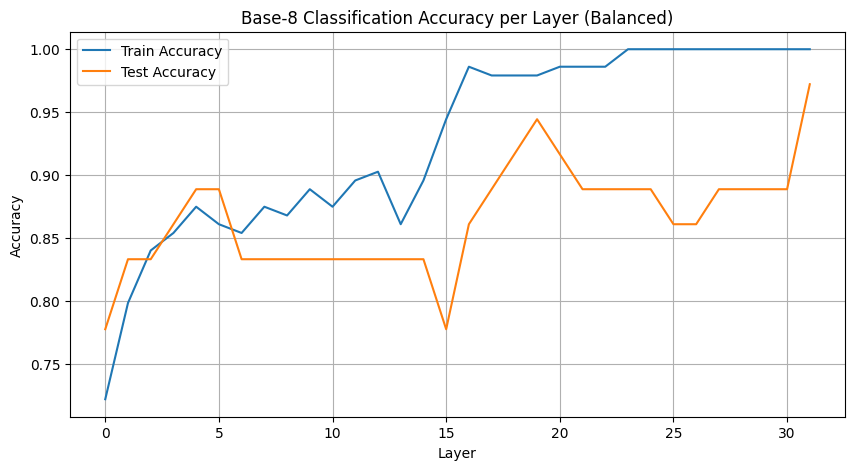

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot accuracy across layers
plt.figure(figsize=(10, 5))

train_accs = [evaluation_results_dict[layer][f'base{base}']['train_acc'] for layer in range(32)]
test_accs = [evaluation_results_dict[layer][f'base{base}']['test_acc'] for layer in range(32)]

plt.plot(range(32), train_accs, label='Train Accuracy')
plt.plot(range(32), test_accs, label='Test Accuracy')

plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title(f'Base-{base} Classification Accuracy per Layer (Balanced)')
plt.legend()
plt.grid(True)


Best layer: 8
Best evaluation results: {'train_acc': 0.6363636363636364, 'test_acc': 0.6231884057971014, 'train_confusion': array([[80, 57],
       [43, 95]]), 'test_confusion': array([[19, 16],
       [10, 24]])}
Loaded data for base8: 1000 examples, 4096 features
Loaded data for base10: 1000 examples, 4096 features
Loaded data for base11: 1000 examples, 4096 features
base8: 172 correct, 826 incorrect examples
base10: 982 correct, 17 incorrect examples
base11: 64 correct, 923 incorrect examples
Loaded data for base8: 1000 examples, 4096 features
Loaded data for base10: 1000 examples, 4096 features
Loaded data for base11: 1000 examples, 4096 features
base8: 172 correct, 826 incorrect examples
base10: 982 correct, 17 incorrect examples
base11: 64 correct, 923 incorrect examples
Loaded data for base8: 1000 examples, 4096 features
Loaded data for base10: 1000 examples, 4096 features
Loaded data for base11: 1000 examples, 4096 features
base8: 172 correct, 826 incorrect examples
base10: 982

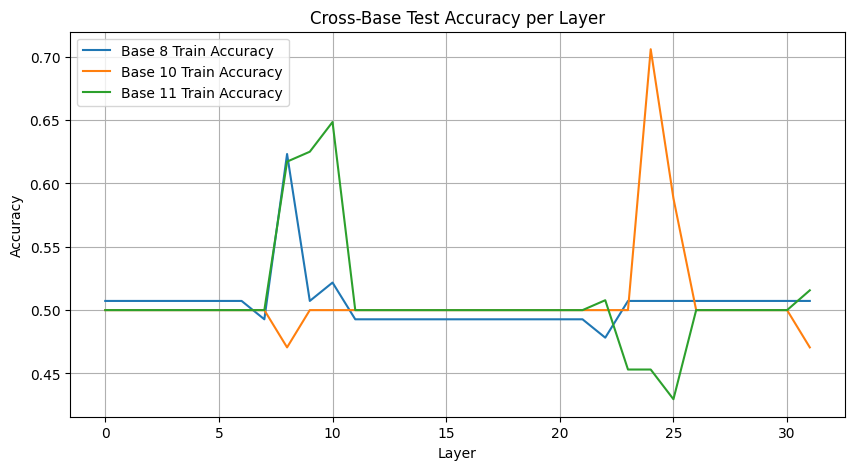

In [ ]:
# Get the best classifier performance:
best_layer = np.argmax(test_accs)
best_classifier = classifieres_dict[best_layer][f'base{base}']
best_evaluation_results = evaluation_results_dict[best_layer][f'base{base}']

print(f"Best layer: {best_layer}")
print(f"Best evaluation results: {best_evaluation_results}")

# Evaluate this classifier on base 10 and base 11
bases = [8, 10, 11]
balance = True

cross_base_evaluation_results_dict = {}

# Load data
for layer in range(32):
    cross_base_evaluation_results_dict[layer] = {}
    data = load_data(layer, bases)
    
    # Prepare datasets
    datasets = prepare_datasets(data, balance)



    for base_key in datasets:
        if f'base{base}' in base_key:
            X_val = datasets[base_key]['X_test']
            y_val = datasets[base_key]['y_test']
        else:
            X_val = np.vstack([datasets[base_key]['X_train'], datasets[base_key]['X_test']])
            y_val = np.hstack([datasets[base_key]['y_train'], datasets[base_key]['y_test']])

        #y_pred = classifieres_dict[layer][f'base{base}'].predict(X_val)
        y_pred = best_classifier.predict(X_val)
        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        # Calculate confusion matrix
        confusion = confusion_matrix(y_val, y_pred)
        cross_base_evaluation_results_dict[layer][base_key] = {
            'val_accuracy': accuracy,
            'val_confusion': confusion
        }

# Plot the cross-base evaluation results
plt.figure(figsize=(10, 5))


for base in bases:
    train_accs = [cross_base_evaluation_results_dict[layer][f'base{base}']['val_accuracy'] for layer in range(32)]
    plt.plot(range(32), train_accs, label=f'Base {base} Train Accuracy')

plt.xlabel('Layer')
plt.ylabel('Accuracy') 
plt.title('Cross-Base Test Accuracy per Layer')
plt.legend()
plt.grid(True)

Text(95.72222222222221, 0.5, 'Actual')

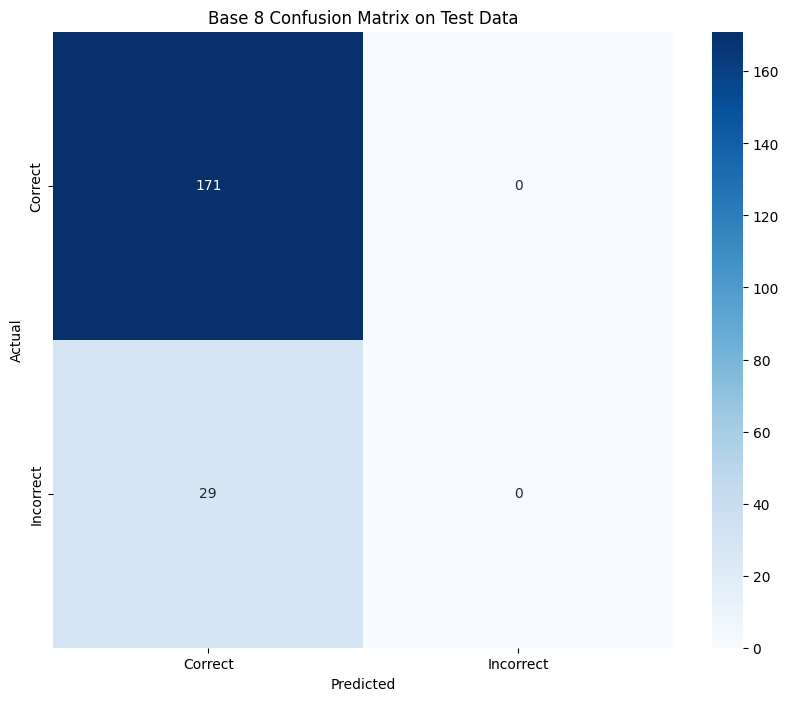

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the base 8 confusion matrix on test data
plt.figure(figsize=(10, 8))
sns.heatmap(evaluation_results['base8']['test_confusion'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Correct', 'Incorrect'], yticklabels=['Correct', 'Incorrect'])
plt.title('Base 8 Confusion Matrix on Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [2]:
data = json.load(open("arithmetic_classifier_results.json"))

print(data)

{'0': {'evaluation': {'base8': {'train_acc': 0.8208020050125313, 'test_acc': 0.855, 'cross_acc': {'base10': 0.01, 'base11': 0.9444444444444444}}, 'base10': {'train_acc': 0.981226533166458, 'test_acc': 0.99, 'cross_acc': {'base8': 0.145, 'base11': 0.05555555555555555}}, 'base11': {'train_acc': 0.9328263624841572, 'test_acc': 0.9444444444444444, 'cross_acc': {'base8': 0.855, 'base10': 0.01}}}, 'correlation': [[0.9999999999999999, 0.6108134406262977, 0.2472806761662235], [0.6108134406262977, 0.9999999999999998, 0.2949272597918759], [0.2472806761662235, 0.2949272597918759, 1.0]]}, '1': {'evaluation': {'base8': {'train_acc': 0.8208020050125313, 'test_acc': 0.855, 'cross_acc': {'base10': 0.01, 'base11': 0.9444444444444444}}, 'base10': {'train_acc': 0.981226533166458, 'test_acc': 0.99, 'cross_acc': {'base8': 0.145, 'base11': 0.05555555555555555}}, 'base11': {'train_acc': 0.9328263624841572, 'test_acc': 0.9444444444444444, 'cross_acc': {'base8': 0.855, 'base10': 0.01}}}, 'correlation': [[1.0, 

In [ ]:
# Plot the base 8 train and test accuracy per layer

plt.figure(figsize=(10, 5))
plt.plot([data[str(layer)]['evaluation']['base8']['train_acc'] for layer in range(32)], label='Base 8 Train Accuracy')
plt.plot([data[str(layer)]['evaluation']['base8']['test_acc'] for layer in range(32)], label='Base 8 Test Accuracy')
plt.axhline(y=826/(1000), color='r', linestyle='--', label='Majority Class Accuracy')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('Base 8 Train and Test Accuracy per Layer')
plt.legend()

NameError: name 'plt' is not defined

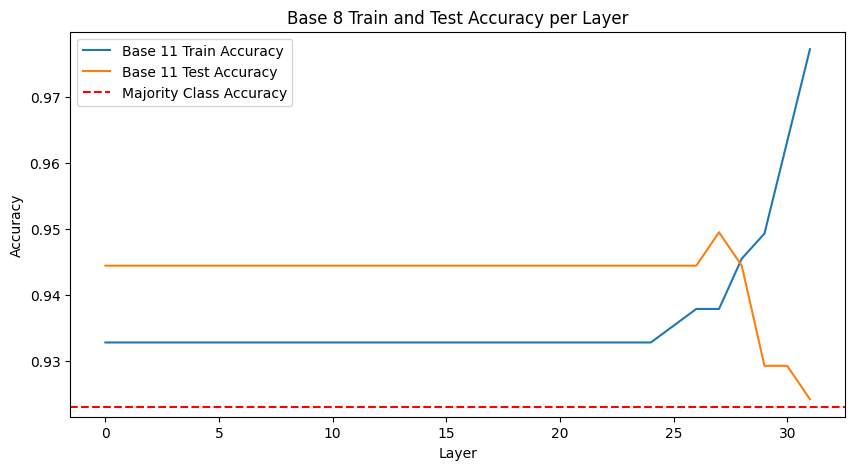

In [9]:
# Plot the base 8 train and test accuracy per layer

plt.figure(figsize=(10, 5))
plt.plot([data[str(layer)]['evaluation']['base11']['train_acc'] for layer in range(32)], label='Base 11 Train Accuracy')
plt.plot([data[str(layer)]['evaluation']['base11']['test_acc'] for layer in range(32)], label='Base 11 Test Accuracy')
plt.axhline(y=923/(1000), color='r', linestyle='--', label='Majority Class Accuracy')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('Base 8 Train and Test Accuracy per Layer')
plt.legend()

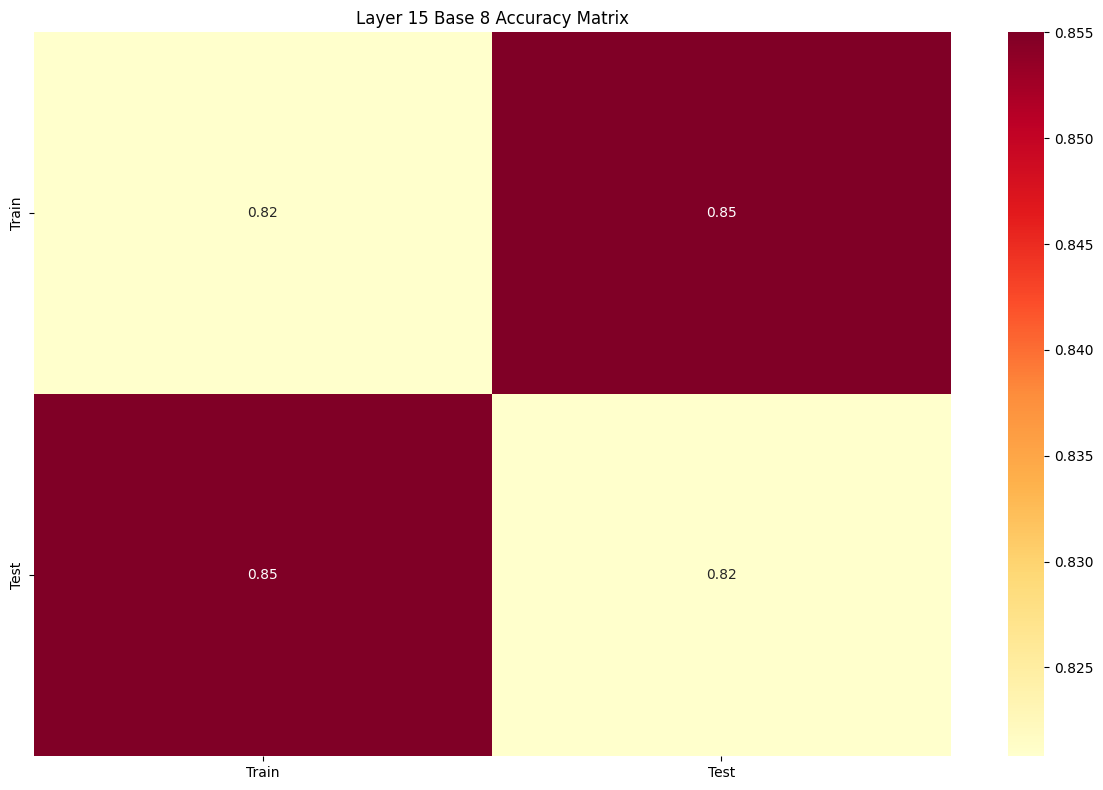

In [12]:
import seaborn as sns
# Plot confusion matrix for layer 15
layer = 15

plt.figure(figsize=(12, 8))

# Base 8 accuracy
base8_train = data[str(layer)]['evaluation']['base8']['train_acc']
base8_test = data[str(layer)]['evaluation']['base8']['test_acc']

base8_matrix = [[base8_train, base8_test],
                [base8_test, base8_train]]

sns.heatmap(base8_matrix, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=['Train', 'Test'],
            yticklabels=['Train', 'Test'])
plt.title(f'Layer {layer} Base 8 Accuracy Matrix')

plt.tight_layout()
